In [1]:
from skimage import io, exposure

import numpy as np
import scipy
import scipy.ndimage
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import time

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sched

In [3]:
from scipy.fft import ifftn, fftn, fft2, ifft2

In [4]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
def MinMaxNormalization(tensor):
    #min max normalization
    v_min, v_max = tensor.min(), tensor.max()
    tensor = (tensor - v_min)/(v_max - v_min)
    return tensor

In [6]:
def ReadAndCrop256Img(path):
    input_img = io.imread(path)
    temp = input_img[0:64,0:64,0:64]
    output_img = torch.from_numpy(temp).float()
    output_img = output_img.reshape([1,1,64,64,64])
    
    for i in range(6):
        for j in range(6):
            for k in range(6):
                i1 = int(i/2)
                j1 = int(j/2)
                k1 = int(k/2)
                temp = input_img[(i1*64):((i1+1)*64),(j1*64):((j1+1)*64), (k1*64):((k1+1)*64)]
                output_img_temp = torch.from_numpy(temp).float()
                output_img_temp = output_img_temp.reshape([1,1,64,64,64])
                output_img = torch.cat((output_img,output_img_temp), dim = 0)
    
    return output_img


def ReadAndCrop256ImgNorm(path):
    input_img = io.imread(path)
    temp = input_img[0:64,0:64,0:64]
    output_img = torch.from_numpy(temp).float()
    output_img = output_img.reshape([1,1,64,64,64])
    
    for i in range(6):
        for j in range(6):
            for k in range(6):
                i1 = int(i/2)
                j1 = int(j/2)
                k1 = int(k/2)
                temp = input_img[(i1*64):((i1+1)*64),(j1*64):((j1+1)*64), (k1*64):((k1+1)*64)]
                output_img_temp = torch.from_numpy(temp).float()
                output_img_temp = output_img_temp.reshape([1,1,64,64,64])
                output_img_temp = MinMaxNormalization(output_img_temp)
                output_img = torch.cat((output_img,output_img_temp), dim = 0)
    
    return output_img

In [7]:
def ReadTrainingSet(path_list):
    output = torch.zeros(1,1,64,64,64)
    for path in path_list:
        output = torch.cat((output, ReadAndCrop256Img(path)), dim = 0)
    output = output[1:,:,:,:]
    return output

def ReadTrainingSetNorm(path_list):
    output = torch.zeros(1,1,64,64,64)
    for path in path_list:
        output = torch.cat((output, ReadAndCrop256ImgNorm(path)), dim = 0)
    output = output[1:,:,:,:]
    return output

In [8]:
path_list_input = [ ]
path_list_input.append("dataset_cracks/input/crack_1_256_w3_1.tif")
path_list_input.append("dataset_cracks/input/crack_2_256_w3_6.tif")
path_list_input.append("dataset_cracks/input/crack_2_256_w3_10.tif")
#path_list_input.append("dataset_cracks/input/crack_1_256_w5_1.tif")
#path_list_input.append("dataset_cracks/input/crack_2_256_w5_6.tif")
#path_list_input.append("dataset_cracks/input/crack_2_256_w5_8.tif")


path_list_label = [ ]
path_list_label.append("dataset_cracks/labels/crack_1_256_w3_1.tif")
path_list_label.append("dataset_cracks/labels/crack_2_256_w3_6.tif")
path_list_label.append("dataset_cracks/labels/crack_2_256_w3_10.tif")
#path_list_label.append("dataset_cracks/labels/crack_1_256_w5_1.tif")
#path_list_label.append("dataset_cracks/labels/crack_2_256_w5_6.tif")
#path_list_label.append("dataset_cracks/labels/crack_2_256_w5_8.tif")

path_list_weight = [ ]
path_list_weight.append("dataset_cracks/label+weights/crack_1_256_w3_1.tif")
path_list_weight.append("dataset_cracks/label+weights/crack_2_256_w3_6.tif")
path_list_weight.append("dataset_cracks/label+weights/crack_2_256_w3_10.tif")
#path_list_weight.append("dataset_cracks/label+weights/crack_1_256_w5_1.tif")
#path_list_weight.append("dataset_cracks/label+weights/crack_2_256_w5_6.tif")
#path_list_weight.append("dataset_cracks/label+weights/crack_2_256_w5_8.tif")

In [9]:
def ReadTrainingSetWithRotation(path_list):
    output_img = torch.empty(5,3,0)
    for path in path_list:
        output = torch.cat((output, ReadAndCrop256Img(path)), dim = 0)
        #output = torch.cat((output, torch.))
    return output

In [10]:
def MakeRange(size_n):
    output = np.zeros(size_n)
    center = int(size_n/2)
    for i in range(size_n):
        output[i] = (i-center)/(size_n - (size_n%2))
    return output

# RieszNet

In [11]:
def RieszKernel3DFirstOrder(s_x, s_y, s_z):
    #get riesz kernel in fourier domain
    size_x = s_x
    size_y = s_y
    size_z = s_z
    Riesz_kernel100 = np.zeros([size_x, size_y,size_z], dtype=complex)
    Riesz_kernel010 = np.zeros([size_x, size_y,size_z], dtype=complex)
    Riesz_kernel001 = np.zeros([size_x, size_y,size_z], dtype=complex)
    gx = MakeRange(size_x)
    gy = MakeRange(size_y)
    gz = MakeRange(size_z)
    for i in range(size_x):
        for j in range(size_y):
            for k in range(size_z):
                den = gx[i]*gx[i]+gy[j]*gy[j]+gz[k]*gz[k]
                if den > 1e-08:
                    #1st order
                    den = np.sqrt(den)
                    Riesz_kernel010[k,i,j] = complex(0,-gy[j]/den)
                    Riesz_kernel100[k,i,j] = complex(0,-gx[i]/den)
                    Riesz_kernel001[k,i,j] = complex(0,-gz[k]/den)
                    
    Riesz_kernel100 = torch.from_numpy(Riesz_kernel100)
    Riesz_kernel100 = Riesz_kernel100.reshape([1,1,size_x,size_y,size_z])
    
    Riesz_kernel010 = torch.from_numpy(Riesz_kernel010)
    Riesz_kernel010 = Riesz_kernel010.reshape([1,1,size_x,size_y,size_z])
    Riesz_kernel001 = torch.from_numpy(Riesz_kernel001)
    
    Riesz_kernel001 = Riesz_kernel001.reshape([1,1,size_x,size_y,size_z])
    return [Riesz_kernel100, Riesz_kernel010, Riesz_kernel001]

In [12]:
class RieszNet(nn.Module):

    def __init__(self):
        super(RieszNet, self).__init__()
        self.size = 64
        self.size_x = self.size 
        self.size_y = self.size 
        self.size_z = self.size 
        
        [self.Rx, self.Ry, self.Rz] = RieszKernel3DFirstOrder(self.size_x, self.size_y, self.size_z)

    def forward(self, x):
        if x.size()[3] != self.size_x or x.size()[4] != self.size_y or x.size()[2] != self.size_z:
            self.size_x = x.size()[3]
            self.size_y = x.size()[4]
            self.size_z = x.size()[2]
            [self.Rx, self.Ry, self.Rz] = RieszKernel3DFirstOrder(self.size_x, self.size_y, self.size_z)
        
        x = torch.fft.fftn(x, dim = [2,3,4])
        #x = torch.fft.fftshift(x)
        x = torch.fft.fftshift(x, dim = [2,3,4])
        
        x1 = self.Rx*x
        x2 = self.Ry*x
        x9 = self.Rz*x
        #x3 = self.Rxx(x)
        x3 = -self.Rx*x1
        #x4 = self.Rxy(x)
        x4 = -self.Rx*x2
        #x5 = self.Ryy(x)
        x5 = -self.Ry*x2
        #x6 = self.Rzz(x)
        x6 = -self.Rz*x9
        #x7 = self.Rxz(x)
        x7 = -self.Rz*x1
        #x8 = self.Ryz(x)
        x8 = -self.Ry*x9
        
        x = torch.cat((x1, x2, x3, x4, x5, x6, x7, x8, x9), dim=1)
        x = torch.fft.ifftshift(x, dim = [2,3,4])
        x = torch.real(torch.fft.ifftn(x, dim = [2,3,4])).double()
        
        return x

In [13]:
class RieszNetDeep(nn.Module):

    def __init__(self):
        super(RieszNetDeep, self).__init__()
        
        self.conv5 = nn.Conv3d(32,1,kernel_size = (1,1,1))
        self.seq1 = nn.Sequential(nn.Conv3d(9,16,kernel_size = (1,1,1),dtype=torch.float32),nn.BatchNorm3d(16, affine=False),nn.ReLU())
        self.seq2 = nn.Sequential(nn.Conv3d(144,16,kernel_size = (1,1,1),dtype=torch.float32),nn.BatchNorm3d(16, affine=False),nn.ReLU())
        self.seq3 = nn.Sequential(nn.Conv3d(144,32,kernel_size = (1,1,1),dtype=torch.float32),nn.BatchNorm3d(32, affine=False),nn.ReLU())
        
        self.GL1 = RieszNet()

    def forward(self, x):
    
        #1st Riesz layer
        x = self.GL1(x)
        x = x.float()
        gc.collect()
        x = self.seq1(x)
        gc.collect()

        #2nd Riesz layer
        x = self.GL1(x)
        x = x.float()
        gc.collect()
        x = self.seq2(x)
        
        #3rd Riesz layer
        x = self.GL1(x)
        x = x.float()
        gc.collect()
        x = self.seq3(x)
        gc.collect()
        
        #final layer
        x = x.float()
        x = self.conv5(x)
        gc.collect()
        x = F.sigmoid(x)
        return x
    
    def forward_seq(self, x):
        
        #1st Riesz layer
        x = self.GL1(x)
        x = x.float()
        gc.collect()
        x = self.seq1(x)
        gc.collect()
        
        #2nd Riesz layer
        myconv = nn.Conv3d(9,16,kernel_size = (1,1,1),dtype=torch.float32, bias = False)
        myconv.weight.data.zero_()
        myconv.load_state_dict({'bias': self.seq1[0].bias})
        z = myconv(x)
        for i in range(16):
            y = self.GL1(x[:,(i*9):((i+1)*9),:,:,:])
            y = y.float()           
            myconv.load_state_dict({'weight': self.seq1[0].weight[:,(i*9):((i+1)*9),:,:,:]})
            z = z + myconv(y)
        x = self.seq1[1:](z)
        
        gc.collect()
        x = self.seq2(x)
        
        #3rd Riesz layer
        x = self.GL1(x)
        x = x.float()
        gc.collect()
        x = self.seq3(x)
        gc.collect()
        
        #final layer
        x = x.float()
        x = self.conv5(x)
        gc.collect()
        x = F.sigmoid(x)
        return x

# Train

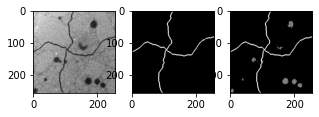

In [14]:
path_input = 'dataset_cracks/input/crack_2_256_w3_6.tif'
test_full = io.imread(path_input)
temp1 = test_full[1,:,:]
test = torch.from_numpy(temp1).float()
test_full2 = test.reshape([1,1,256,256])
test_full2 = MinMaxNormalization(test_full2)


path_label = 'dataset_cracks/label/crack_2_256_w3_6.tif'
test_fully = io.imread(path_label)
temp2 = test_fully[1,:,:]
test = torch.from_numpy(temp2).float()
test_fully2 = test.reshape([1,1,256,256])


path_weight = 'dataset_cracks/label+weights/crack_2_256_w3_6.tif'
test_fullw = io.imread(path_weight)
temp3 = test_fullw[1,:,:]
test = torch.from_numpy(temp3).float()
test_fullyw = test.reshape([1,1,256,256])


fig, ax = plt.subplots(1,3, figsize=(5,5))
ax[0].imshow(temp1, cmap='gray')
ax[1].imshow(temp2, cmap='gray')
ax[2].imshow(temp3, cmap='gray')

In [15]:
test_x2 = ReadTrainingSetNorm(path_list_input)
print(test_x2.size())

test_y2 = ReadTrainingSet(path_list_label)
print(test_y2.size())

test_w2 = ReadTrainingSet(path_list_weight)
print(test_w2.size())

test_x2 = test_x2.double()
test_y2 = test_y2.double()
test_w2 = test_w2.double()

torch.Size([1302, 1, 64, 64, 64])
torch.Size([1302, 1, 64, 64, 64])
torch.Size([1302, 1, 64, 64, 64])


In [22]:
LN = RieszNetDeep()

count_parameters(LN)

weights = 40*test_w2+1

7153

In [24]:
import time
import gc
import sys

gc.collect()

861

In [25]:
input2 = test_x2[10:20,:,:,:,:]
target2 = test_y2[10:20,:,:,:,:]
input_w = weights[10:20,:,:,:,:]

print(input2.size())
model = LN
#model = LN.double()

tic = time.perf_counter()
criterion = nn.BCELoss(weight=input_w)
k = model(input2.float())
loss = criterion(k.float(), target2.float())
toc = time.perf_counter()
print(toc-tic)

torch.Size([10, 1, 64, 64, 64])
7.406945694005117


/p/bv/mikro/home/barisin/Franziska-NN2/TinNN/lib64/python3.6/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [26]:
model = LN.float()

n_epochs = 20 # or whatever
batch_size = 2 # or whatever
train_num = 1302

optimizer = optim.Adam(model.parameters(), lr = 0.005)
scheduler = sched.StepLR(optimizer, step_size=5, gamma=0.5)

input = test_x2.float()
target = test_y2.float()
input_w = weights.float()


for epoch in range(n_epochs):

    # X is a torch Variable
    permutation = torch.randperm(train_num)
    if(epoch % 2 == 1):
        print(epoch)
        print(t_loss/train_num)
    t_loss = 0
    for i in range(0,train_num, batch_size):
        optimizer.zero_grad()
        indices = permutation[i:(i+batch_size)]
        batch_x = input[indices]
        batch_y = target[indices]
        batch_w = input_w[indices]
        criterion3 = nn.BCELoss(weight=batch_w)
        
        outputs = model.forward(batch_x.float())
        loss = criterion3(outputs,batch_y)
        
        if(epoch % 2 == 0):
            t_loss += loss

        loss.backward()
        optimizer.step() 
        
    gc.collect()
    scheduler.step()

/p/bv/mikro/home/barisin/Franziska-NN2/TinNN/lib64/python3.6/site-packages/torch/autograd/__init__.py:149: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /pytorch/aten/src/ATen/native/Copy.cpp:240.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


1
tensor(0.5161, grad_fn=<DivBackward0>)
3
tensor(0.2454, grad_fn=<DivBackward0>)
5
tensor(0.1936, grad_fn=<DivBackward0>)
7
tensor(0.1449, grad_fn=<DivBackward0>)
9
tensor(0.1384, grad_fn=<DivBackward0>)
11
tensor(0.1205, grad_fn=<DivBackward0>)
13
tensor(0.1158, grad_fn=<DivBackward0>)
15
tensor(0.1102, grad_fn=<DivBackward0>)
17
tensor(0.1033, grad_fn=<DivBackward0>)
19
tensor(0.1020, grad_fn=<DivBackward0>)


In [27]:
torch.save(LN.state_dict(), "RieszNet-crack-segmentation-3d.pth")

# Test


In [28]:
input2 = test_x2[10:20,:,:,:,:]
target2 = test_y2[10:20,:,:,:,:]
input_w = weights[10:20,:,:,:,:]

print(input2.size())
model = LN#.double()

tic = time.perf_counter()
k = model(input2.float())
toc = time.perf_counter()
print(toc-tic)
gc.collect()

torch.Size([10, 1, 64, 64, 64])
6.517523657006677


0

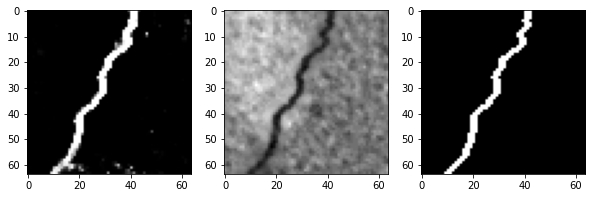

In [29]:
k1 = k[7,0,32,:,:].detach().numpy()
test1 = input2[7,0,32,:,:].detach().numpy()
test2 = target2[7,0,32,:,:].detach().numpy()

fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(k1, cmap='gray')
ax[1].imshow(test1, cmap='gray')
ax[2].imshow(test2, cmap='gray')

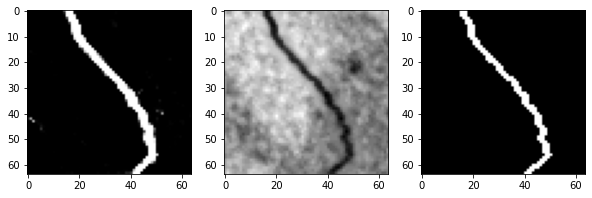

In [30]:
k1 = k[1,0,32,:,:].detach().numpy()
test1 = input2[1,0,32,:,:].detach().numpy()
test2 = target2[1,0,32,:,:].detach().numpy()

fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(k1, cmap='gray')
ax[1].imshow(test1, cmap='gray')
ax[2].imshow(test2, cmap='gray')

In [32]:
path_input = 'dataset_cracks/test_imgs/input/crack_2_256_w3_6.tif'
test_full = io.imread(path_input)
temp1 = test_full[0:64,64:128,64:128]
test = torch.from_numpy(temp1).float()
test_full2 = test.reshape([1,1,64,64,64])
test_full2 = MinMaxNormalization(test_full2)


path_label = 'dataset_cracks/test_imgs/label/crack_2_256_w3_6.tif'
test_fully = io.imread(path_label)
temp2 = test_fully[0:64,64:128,64:128]
test = torch.from_numpy(temp2).float()
test_fully2 = test.reshape([1,1,64,64,64])

In [33]:
test_full2.size()

torch.Size([1, 1, 64, 64, 64])

In [34]:
tic = time.perf_counter()
k = LN(test_full2)
toc = time.perf_counter()
print(toc-tic)
gc.collect()

1.1373260589898564


0

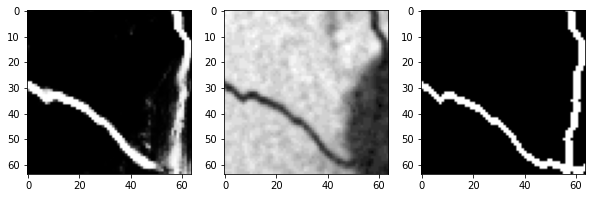

In [35]:
k1 = k[0,0,48,:,:].detach().numpy()
test1 = test_full2[0,0,48,:,:].detach().numpy()
test2 = test_fully2[0,0,48,:,:].detach().numpy()

fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(k1, cmap='gray')
ax[1].imshow(test1, cmap='gray')
ax[2].imshow(test2, cmap='gray')

In [36]:
#seen image from training set
path_input = 'dataset_cracks/input/crack_2_256_w3_10.tif'

test_x = io.imread(path_input)
temp1 = test_x[0:64,64:128,64:128]
test = torch.from_numpy(temp1).float()
test_x2 = test.reshape([1,1,64,64,64])
test_x2 = MinMaxNormalization(test_x2)

k = LN(test_x2)
gc.collect()

0

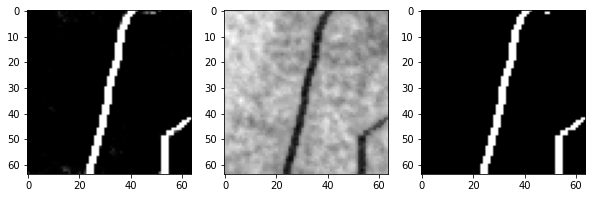

In [37]:
k1 = k[0,0,48,:,:].detach().numpy()
test1 = test_x2[0,0,48,:,:].detach().numpy()
k2 = k1.copy()
t = 0.5
k2[k2 < t] = 0
k2[k2 >= t] = 1


fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(k1, cmap='gray')
ax[1].imshow(test1, cmap='gray')
ax[2].imshow(k2, cmap='gray')

# Validation on unseen image of unseen scale

In [40]:
#validation on unseen image of unseen scale
path_input = 'cracks_dataset/input/crack_1_256_w5_1.tif'

#LN.change_sigma(1.5)

test_x = io.imread(path_input)
temp1 = test_x[0:64,64:128,64:128]
test = torch.from_numpy(temp1).float()
test_x2 = test.reshape([1,1,64,64,64])
test_x2 = MinMaxNormalization(test_x2)

#no sigma adjustment
tic = time.perf_counter()
k = LN(test_x2)
toc = time.perf_counter()
print(toc-tic)
gc.collect()

1.0669455360039137


0

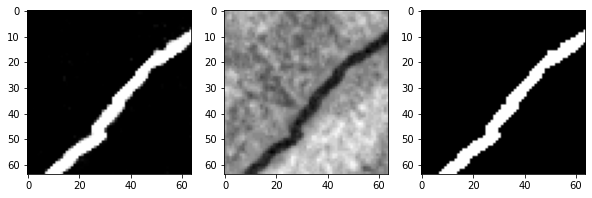

In [41]:
k1 = k[0,0,32,:,:].detach().numpy()
test1 = test_x2[0,0,32,:,:].detach().numpy()
k2 = k1.copy()
t = 0.5
k2[k2 < t] = 0
k2[k2 >= t] = 1


fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(k1, cmap='gray')
ax[1].imshow(test1, cmap='gray')
ax[2].imshow(k2, cmap='gray')

In [42]:
path_ground = 'cracks_dataset/labels/crack_1_256_w5_1.tif'
test_g = io.imread(path_ground)
temp_g = test_g[0:64,64:128,64:128]
temp_g = temp_g.flatten()
k1 = k[0,0,:,:,:].detach().numpy()
k2 = k1.copy()
t = 0.5
k2[k2 < t] = 0
k2[k2 >= t] = 1
k2 = k2.flatten()

print(confusion_matrix(temp_g, k2))

res = []
prec = metrics.precision_score(temp_g, k2)
res.append(prec)
rec = metrics.recall_score(temp_g, k2)
res.append(rec)
f1 = metrics.f1_score(temp_g, k2)
res.append(f1)
print(res)
gc.collect()

[[237494   3019]
 [   131  21500]]
[0.8768709980015498, 0.9939438768434191, 0.931744312026002]


53

In [43]:
path_input = 'cracks_dataset/test_imgs/crack-input-mid.tif'

test_x = io.imread(path_input)
temp1 = test_x[0:64,84:148,84:148]
test = torch.from_numpy(temp1).float()
test_x2 = test.reshape([1,1,64,64,64])
test_x2 = MinMaxNormalization(test_x2)

1.1694154769647866


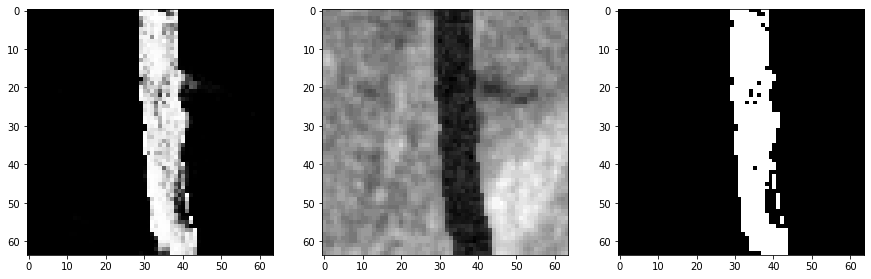

In [44]:
#LN.change_sigma(25)

tic = time.perf_counter()
k = LN(test_x2)
toc = time.perf_counter()
print(toc-tic)

k1 = k[0,0,32,:,:].detach().numpy()
test1 = test_x2[0,0,32,:,:].detach().numpy()
k2 = k1.copy()
t = 0.5
k2[k2 < t] = 0
k2[k2 >= t] = 1


fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(k1, cmap='gray')
ax[1].imshow(test1, cmap='gray')
ax[2].imshow(k2, cmap='gray')

#LN.change_sigma(1.5)

20.128484700981062


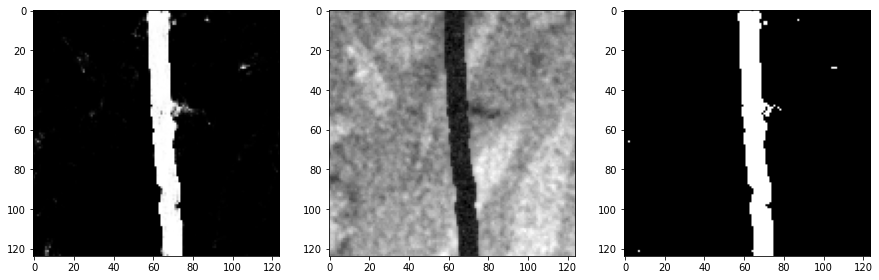

In [45]:
test_x = io.imread(path_input)
temp1 = test_x[0:124,54:178,54:178]
test = torch.from_numpy(temp1).float()
test_x2 = test.reshape([1,1,124,124,124])
test_x2 = MinMaxNormalization(test_x2)

tic = time.perf_counter()
k = LN(test_x2)
toc = time.perf_counter()
print(toc-tic)

k1 = k[0,0,32,:,:].detach().numpy()
test1 = test_x2[0,0,32,:,:].detach().numpy()
k2 = k1.copy()
t = 0.5
k2[k2 < t] = 0
k2[k2 >= t] = 1


fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(k1, cmap='gray')
ax[1].imshow(test1, cmap='gray')
ax[2].imshow(k2, cmap='gray')

#LN.change_sigma(1.5)

In [46]:
path_input = 'cracks_dataset/test_imgs/crack-input-thick.tif'

test_x = io.imread(path_input)
temp1 = test_x[0:64,84:148,84:148]
test = torch.from_numpy(temp1).float()
test_x2 = test.reshape([1,1,64,64,64])
test_x2 = MinMaxNormalization(test_x2)

3.073004713980481


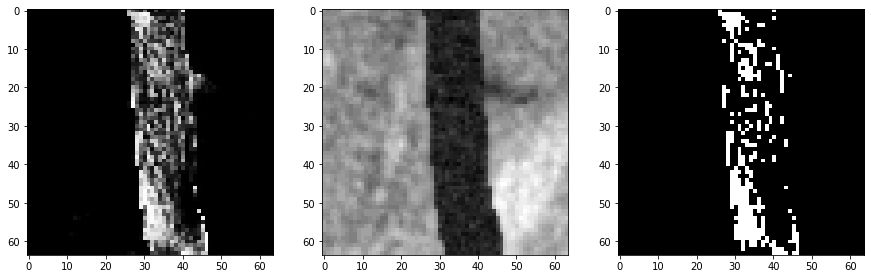

In [47]:
tic = time.perf_counter()
k = LN(test_x2)
toc = time.perf_counter()
print(toc-tic)

k1 = k[0,0,32,:,:].detach().numpy()
test1 = test_x2[0,0,32,:,:].detach().numpy()
k2 = k1.copy()
t = 0.5
k2[k2 < t] = 0
k2[k2 >= t] = 1


fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(k1, cmap='gray')
ax[1].imshow(test1, cmap='gray')
ax[2].imshow(k2, cmap='gray')

#LN.change_sigma(1.5)

In [48]:
gc.collect()

15

In [49]:
path_input = 'cracks_dataset/test_imgs/test_imgs/crack-input-thick.tif'

test_x = io.imread(path_input)
temp1 = test_x[0:124,54:178,54:178]
test = torch.from_numpy(temp1).float()
test_x2 = test.reshape([1,1,124,124,124])
test_x2 = MinMaxNormalization(test_x2)

In [50]:
#LN.change_sigma(25)

tic = time.perf_counter()
k = LN(test_x2)
toc = time.perf_counter()
print(toc-tic)

19.961303730029613


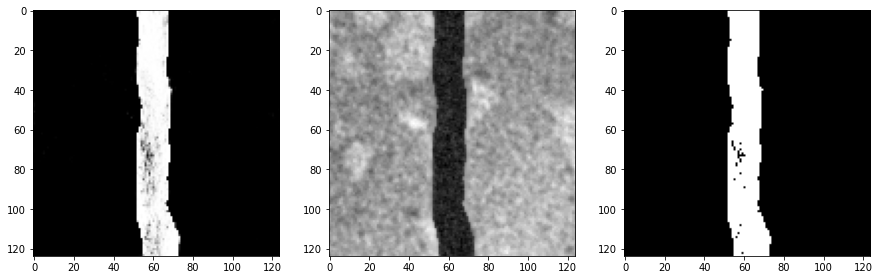

In [51]:
k1 = k[0,0,64,:,:].detach().numpy()
test1 = test_x2[0,0,64,:,:].detach().numpy()
k2 = k1.copy()
t = 0.5
k2[k2 < t] = 0
k2[k2 >= t] = 1


fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(k1, cmap='gray')
ax[1].imshow(test1, cmap='gray')
ax[2].imshow(k2, cmap='gray')

#LN.change_sigma(1.5)

In [52]:
path_input = 'cracks_dataset/test_imgs/crack-input-thick.tif'

test_x = io.imread(path_input)
temp1 = test_x[0:184,24:208,24:208]
test = torch.from_numpy(temp1).float()
test_x2 = test.reshape([1,1,184,184,184])
test_x2 = MinMaxNormalization(test_x2)

In [53]:
gc.collect()

1092

In [54]:
#LN.change_sigma(25)

tic = time.perf_counter()
k = LN(test_x2)
toc = time.perf_counter()
print(toc-tic)

63.322463007993065


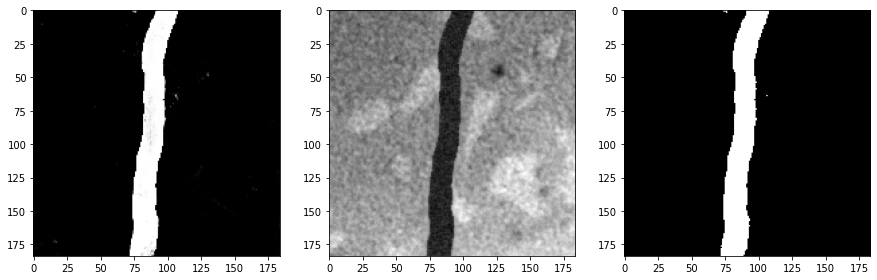

In [55]:
k1 = k[0,0,90,:,:].detach().numpy()
test1 = test_x2[0,0,90,:,:].detach().numpy()
k2 = k1.copy()
t = 0.5
k2[k2 < t] = 0
k2[k2 >= t] = 1


fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(k1, cmap='gray')
ax[1].imshow(test1, cmap='gray')
ax[2].imshow(k2, cmap='gray')

#LN.change_sigma(1.5)